# Preprocessing Data

In [1]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import re

In [2]:
#Import training and test corpus
df_train = pd.read_csv('../kaggle-competition-2/train_data.csv')
df_test = pd.read_csv('../kaggle-competition-2/test_data.csv')

In [23]:
def preprocessing(df):
    sentences = df.copy()
    # Converting all the upper case to lower case to avoid the distinction between them
    sentences['text'] = df['text'].str.lower()
    # Putting the regex for removing the https and www URLs
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

    # Remove the video and links
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r'{link}', '', x))
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r"\[video\]", '', x))

    # Remove html reference characters
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r'&[a-z]+;', '', x))

    # Remove usernames
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r'@[^\s]+', '', x))

    # Removing numbers
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r'\d+', '', x))

    # Removing hashmarks, non-letter characters
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))

    # Removing all extra same letters to a limit of 2, ex. daaaang => daang, nooooooo => noo
    sentences['text'] = sentences['text'].apply(lambda x: re.sub(r"(.)\1+", r"\1\1", x))
        
    return sentences

In [24]:
#Preprocess the senteces 
train_proc = preprocessing(df_train)
test_proc = preprocessing(df_test)

In [25]:
#Create the encoder corpus
enc_corp = pd.concat([train_proc['text'],test_proc['text']])


In [3]:
df_train['text'] = df_train['text'].apply(lambda x: x.split(' '))
df_test['text'] = df_test['text'].apply(lambda x: x.split(' '))
print(max(max(df_train['text'].apply(lambda x: len(x))),max(df_test['text'].apply(lambda x: len(x)))))
print(min(min(df_train['text'].apply(lambda x: len(x))),min(df_test['text'].apply(lambda x: len(x)))))

110
2


In [8]:
data = pd.concat([df_train['text'].apply(lambda x: len(x)),df_test['text'].apply(lambda x: len(x))])

([<matplotlib.axis.XTick at 0x1eea93ded30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

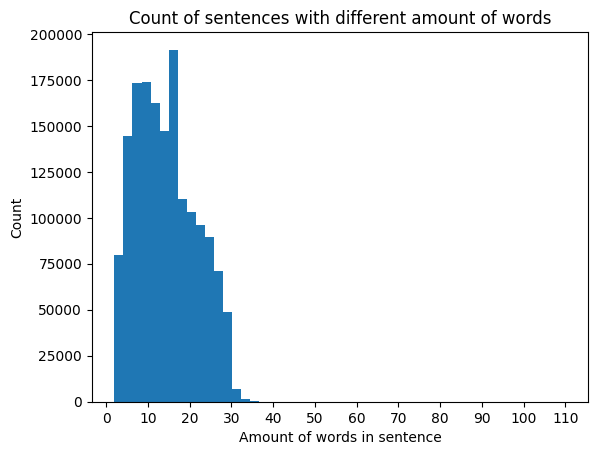

In [15]:
import matplotlib.pyplot as plt
plt.hist(data, bins=50)
plt.xlabel('Amount of words in sentence')
plt.ylabel('Count')
x = list(range(0,120,10))
plt.title('Count of sentences with different amount of words')
plt.xticks(x)

# Word2Vec : CBOW and SkipGram

In [26]:
#Transform sentences to list of words
sentences_corp = enc_corp.apply(lambda x: x.split(' '))
sentences_corp.head()

0           [anyway, im, getting, of, for, a, while, ]
1    [my, red, apache, isn't, feelin, too, well, th...
2    [, you, should, be, , its, great, friday, will...
3    [its, :pm, and, i, dont, wanna, sleep;, so, i,...
4    [why, does, twitter, eat, my, dm's, , not, hap...
Name: text, dtype: object

In [27]:
#Train Word2Vec encoding with Skip-Gram and vector size of 100
word2vec_SkipGram_100d = Word2Vec(sentences=sentences_corp, sg=1, vector_size=100, workers=4)

In [28]:
#Train Word2Vec encoding with Skip-Gram and vector size of 300
word2vec_SkipGram_300d = Word2Vec(sentences=sentences_corp, sg=1, vector_size=300, workers=4)

In [29]:
#Train Word2Vec encoding with Skip-Gram and vector size of 100
word2vec_CBOW_100d = Word2Vec(sentences=sentences_corp, sg=0, vector_size=100, workers=4)

In [30]:
#Train Word2Vec encoding with Skip-Gram and vector size of 300
word2vec_CBOW_300d = Word2Vec(sentences=sentences_corp, sg=0, vector_size=300, workers=4)

In [31]:
#Test our encoding
print(len(list(word2vec_SkipGram_100d.wv.index_to_key)))
print(len(list(word2vec_CBOW_100d.wv.index_to_key)))
print(len(list(word2vec_SkipGram_300d.wv.index_to_key)))
print(len(list(word2vec_CBOW_300d.wv.index_to_key)))

58064
58064
58064
58064


In [32]:
#Find words similar to computer
#We can see that the 300d vector seems less accurate
print(word2vec_SkipGram_100d.wv.most_similar('computer'))
print(word2vec_SkipGram_300d.wv.most_similar('computer'))

[('laptop', 0.8989043831825256), ('pc', 0.8486779928207397), ('comp', 0.8269506096839905), ('lappy', 0.795569658279419), ('compy', 0.7851570248603821), ('hiptop', 0.7809572815895081), ("computer's", 0.7777619361877441), ('lappie', 0.7758223414421082), ('crackberry', 0.7602812051773071), ("'puter", 0.7577412128448486)]
[('laptop', 0.7389435768127441), ('pc', 0.7175706624984741), ('comp', 0.7175503373146057), ('hiptop', 0.625059962272644), ('lappy', 0.6205175518989563), ('compy', 0.6123674511909485), ('lappie', 0.6052822470664978), ("ipod's", 0.6034489274024963), ('puter', 0.596084475517273), ('crackberry', 0.5949008464813232)]


In [33]:
#Find words similar to computer
#Once again the 300d vector seems less accurate
print(word2vec_CBOW_100d.wv.most_similar('computer'))
print(word2vec_CBOW_300d.wv.most_similar('computer'))

[('laptop', 0.9023221135139465), ('pc', 0.8601002097129822), ('comp', 0.8528246879577637), ('internet', 0.7690550088882446), ('lappy', 0.7540048360824585), ('phone', 0.7529410123825073), ('cellphone', 0.733026385307312), ('crackberry', 0.7199079394340515), ('keyboard', 0.7187231183052063), ('blackberry', 0.7149540185928345)]
[('laptop', 0.8617371916770935), ('comp', 0.8138261437416077), ('pc', 0.8056346774101257), ('lappy', 0.6895983219146729), ('keyboard', 0.6700029969215393), ('internet', 0.6550202965736389), ('router', 0.6546667814254761), ('cellphone', 0.6490676403045654), ('phone', 0.6462036967277527), ('ipod', 0.6435583233833313)]


In [34]:
#Save the models
word2vec_SkipGram_100d.save('../Encoders/word2vec_SkipGram_100d')
word2vec_CBOW_100d.save('../Encoders/word2vec_CBOW_100d')

In [35]:
#Example of loading model
new_model = Word2Vec.load('../Encoders/word2vec_CBOW_100d')
new_model.wv.most_similar('computer')

[('laptop', 0.9023221135139465),
 ('pc', 0.8601002097129822),
 ('comp', 0.8528246879577637),
 ('internet', 0.7690550088882446),
 ('lappy', 0.7540048360824585),
 ('phone', 0.7529410123825073),
 ('cellphone', 0.733026385307312),
 ('crackberry', 0.7199079394340515),
 ('keyboard', 0.7187231183052063),
 ('blackberry', 0.7149540185928345)]